# Chapter 2: Understanding Medical Images: Formats & Visualization

This notebook introduces the fundamental concepts of medical image formats and their visualization, with a focus on DICOM and NIfTI formats. We'll learn how to:

1. Load and understand DICOM files
2. Explore DICOM metadata
3. Visualize medical images
4. Apply basic image processing techniques
5. Work with image series

## Prerequisites
- Basic Python programming knowledge
- Understanding of basic image processing concepts
- Familiarity with NumPy arrays

## Required Libraries
We'll be using the following Python libraries:
- `pydicom`: For reading and manipulating DICOM files
- `nibabel`: For working with NIfTI and other neuroimaging formats
- `matplotlib`: For image visualization
- `numpy`: For numerical operations
- `pillow`: For general image processing

## Dataset
This tutorial uses the example-dicom-structural dataset, which contains anonymized T1-weighted brain scans. The dataset is located in the `data/example-dicom-structural/dicoms` directory.

## Troubleshooting
If you encounter any issues:
1. Make sure all required packages are installed: `pip install -r requirements.txt`
2. Ensure you're running the notebook from the correct directory
3. Check that the dataset has been downloaded correctly
4. For visualization issues, try restarting the kernel: Kernel > Restart Kernel


In [2]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

# Configure matplotlib for inline display
%matplotlib inline
plt.style.use('default')  # Using default style for better medical image visualization

# Set up paths to our example data
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 
                       "chapter_02_medical_image_formats_visualization/data/example-dicom-structural/dicoms")

# Verify the data directory exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}\nPlease make sure you've downloaded the dataset.")


## Understanding DICOM Format

DICOM (Digital Imaging and Communications in Medicine) is the international standard for medical images and related information. It defines the formats and processes for storing, handling, and transmitting medical imaging information.

Key features of DICOM:
1. Contains both pixel data and metadata
2. Supports multiple modalities (CT, MRI, X-Ray, etc.)
3. Includes patient information and acquisition parameters
4. Enables interoperability between medical devices

Let's explore a DICOM file from our example dataset:


In [3]:
# Load a DICOM file
dicom_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.dcm')])
if dicom_files:
    # Load the first DICOM file
    dicom_path = os.path.join(DATA_DIR, dicom_files[0])
    ds = pydicom.dcmread(dicom_path)
    
    # Display some basic metadata
    print("Patient Name:", ds.PatientName)
    print("Modality:", ds.Modality)
    print("Study Date:", ds.StudyDate)
    print("Image Size:", ds.Rows, "x", ds.Columns)
    print("Number of DICOM files:", len(dicom_files))
    
    print("\nOther DICOM Tags:")
    print("-" * 40)
    for tag in [
        'ImageType', 'ScanningSequence', 'SequenceVariant',
        'MagneticFieldStrength', 'EchoTime', 'RepetitionTime',
        'SliceThickness', 'SpacingBetweenSlices'
    ]:
        if hasattr(ds, tag):
            print(f"{tag}: {getattr(ds, tag)}")
else:
    print("No DICOM files found in the specified directory")


Patient Name: Jane_Doe
Modality: MR
Study Date: 20130717
Image Size: 384 x 274
Number of DICOM files: 384

Other DICOM Tags:
----------------------------------------
ImageType: ['DERIVED', 'SECONDARY']
SliceThickness: 0.666666686534882
SpacingBetweenSlices: 0.666666686534882


## Visualizing Medical Images

Medical images often require special handling for visualization due to their high bit depth and dynamic range. Let's learn how to properly display a DICOM image:


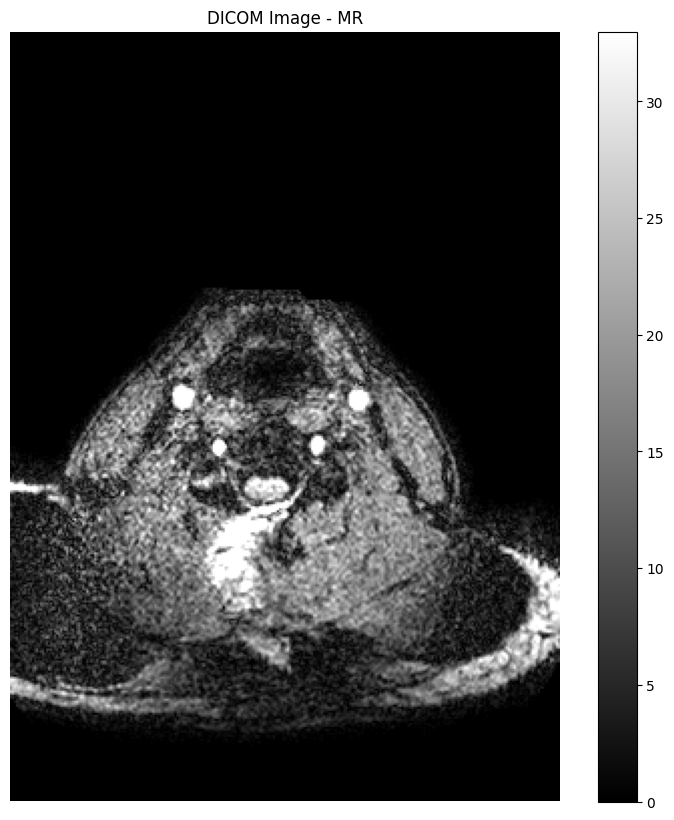

Image Statistics:
Min value: 0
Max value: 99
Mean value: 5.08
Standard deviation: 8.34


In [4]:
def display_dicom_image(dicom_data, title=None, cmap='gray', vmin=None, vmax=None):
    """
    Display a DICOM image with proper windowing
    
    Args:
        dicom_data: PyDICOM dataset
        title: Optional title for the plot
        cmap: Colormap to use (default: gray)
        vmin: Minimum value for windowing (if None, auto-calculated)
        vmax: Maximum value for windowing (if None, auto-calculated)
    """
    # Get pixel array
    img = dicom_data.pixel_array
    
    # Auto-calculate window values if not provided
    if vmin is None:
        vmin = np.percentile(img, 1)  # 1st percentile to remove outliers
    if vmax is None:
        vmax = np.percentile(img, 99)  # 99th percentile to remove outliers
    
    # Create the figure
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    
    if title:
        plt.title(title)
    
    # Add colorbar
    plt.colorbar()
    plt.show()
    
    # Print image statistics
    print(f"Image Statistics:")
    print(f"Min value: {img.min()}")
    print(f"Max value: {img.max()}")
    print(f"Mean value: {img.mean():.2f}")
    print(f"Standard deviation: {img.std():.2f}")

# Display the DICOM image if we have one loaded
if 'ds' in locals():
    display_dicom_image(ds, title=f"DICOM Image - {ds.Modality}")
else:
    print("No DICOM image loaded to display")


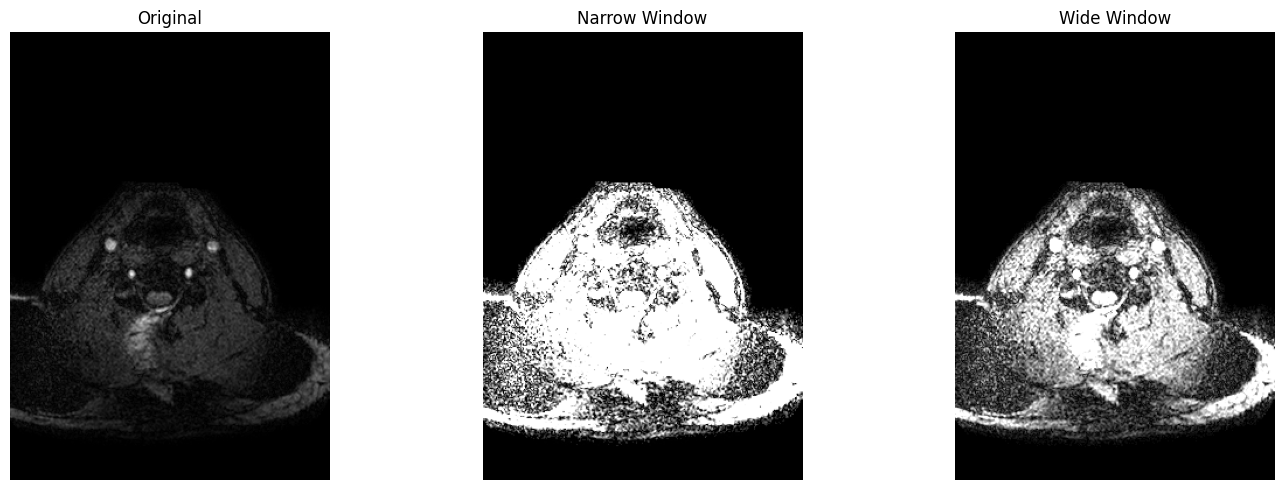

In [5]:
def apply_windowing(dicom_data, window_center=None, window_width=None):
    """
    Apply windowing to a DICOM image
    
    Args:
        dicom_data: PyDICOM dataset
        window_center: Center of window (if None, use DICOM tag or auto-calculate)
        window_width: Width of window (if None, use DICOM tag or auto-calculate)
    
    Returns:
        Windowed image array normalized to [0, 1]
    """
    # Get pixel array
    img = dicom_data.pixel_array.astype(float)
    
    # If window center/width not provided, try to get from DICOM tags
    if window_center is None:
        if hasattr(dicom_data, 'WindowCenter'):
            window_center = dicom_data.WindowCenter
        else:
            # Auto-calculate: use mean as window center
            window_center = np.mean(img)
    
    if window_width is None:
        if hasattr(dicom_data, 'WindowWidth'):
            window_width = dicom_data.WindowWidth
        else:
            # Auto-calculate: use 2 standard deviations as window width
            window_width = 2 * np.std(img)
    
    # Apply windowing
    img_min = window_center - window_width/2
    img_max = window_center + window_width/2
    
    # Clip and normalize
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / (img_max - img_min)
    
    return img

# Display the same image with different windowing settings
if 'ds' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(ds.pixel_array, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Narrow window
    narrow = apply_windowing(ds, window_width=np.std(ds.pixel_array))
    axes[1].imshow(narrow, cmap='gray')
    axes[1].set_title('Narrow Window')
    axes[1].axis('off')
    
    # Wide window
    wide = apply_windowing(ds, window_width=4*np.std(ds.pixel_array))
    axes[2].imshow(wide, cmap='gray')
    axes[2].set_title('Wide Window')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No DICOM image loaded to display")


## Working with Multiple DICOM Files

In medical imaging, we often work with series of images (e.g., different slices of a 3D volume). Let's learn how to load and visualize multiple DICOM files from the same series:


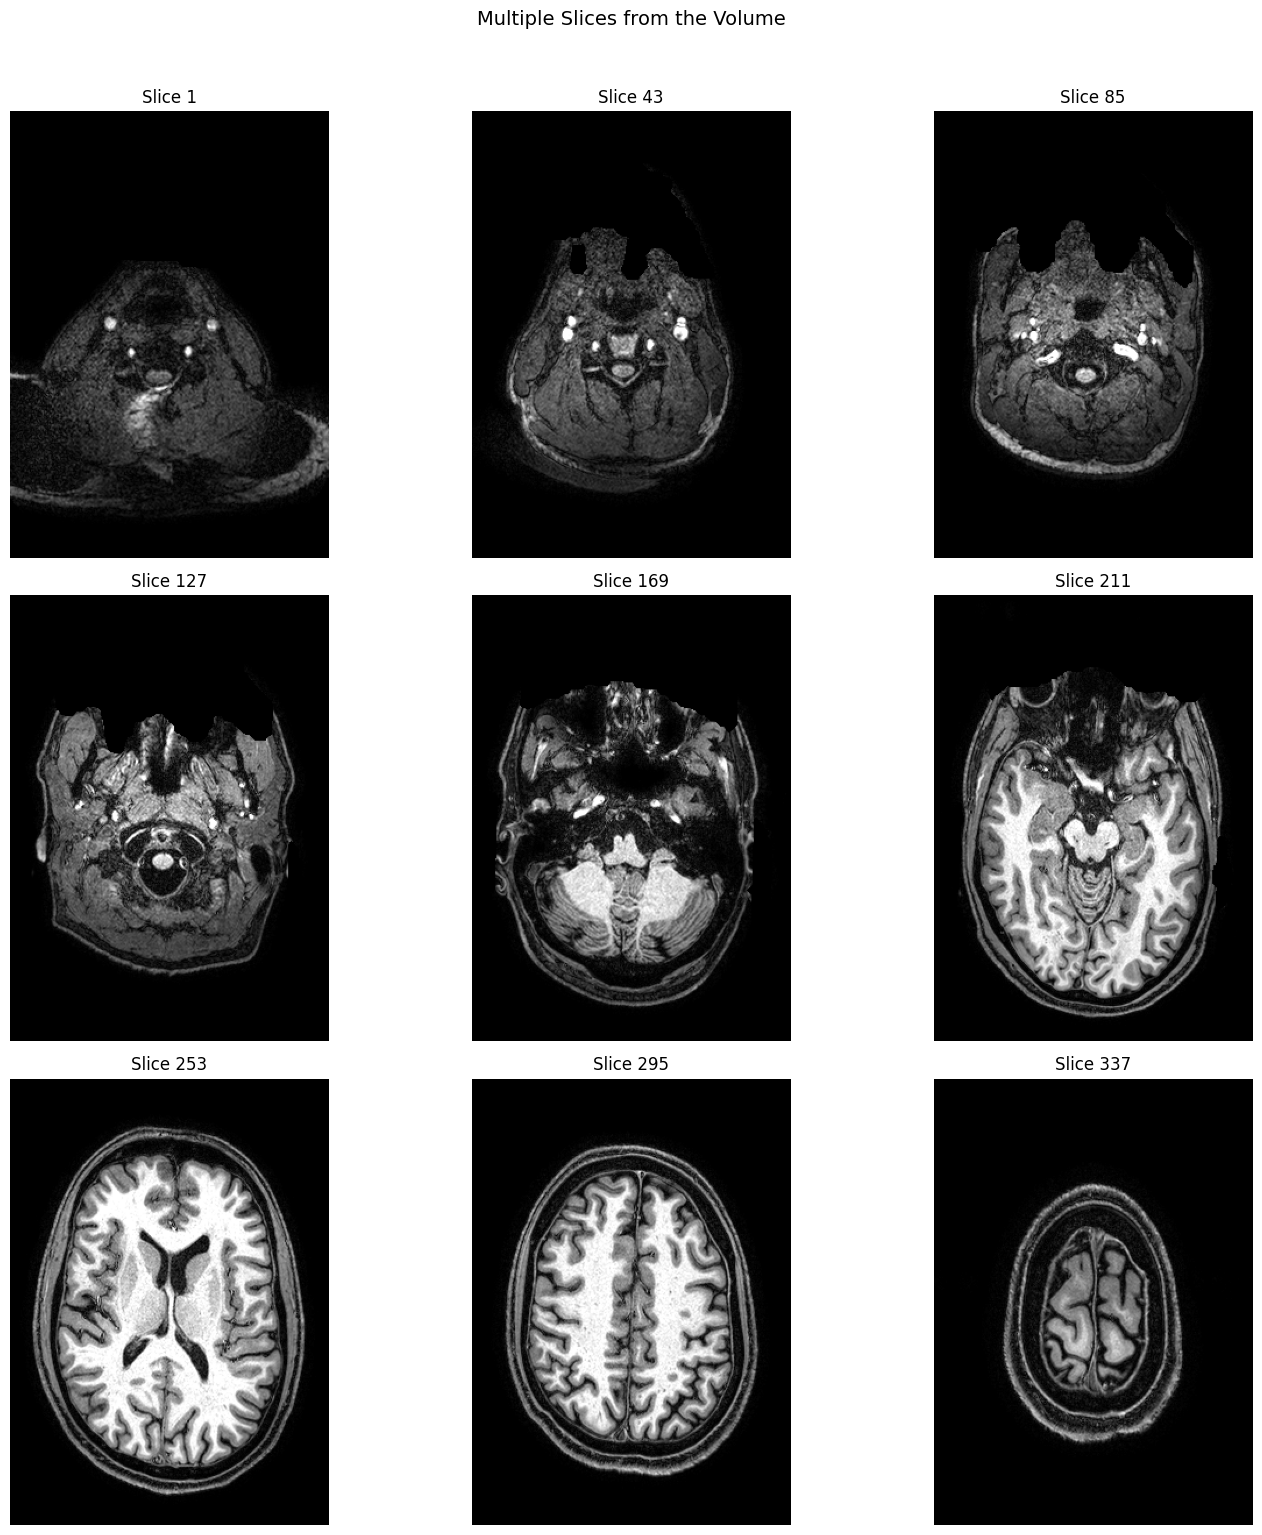

Displaying 9 slices from a total of 384 images


In [6]:
# Load all DICOM files in the directory
dicom_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.dcm')])

# Load the first few slices (up to 9)
num_slices = min(9, len(dicom_files))
slices = []

# Calculate step size to get evenly spaced slices through the volume
step = max(1, len(dicom_files) // num_slices)
slice_indices = range(0, len(dicom_files), step)[:num_slices]

for idx in slice_indices:
    ds = pydicom.dcmread(os.path.join(DATA_DIR, dicom_files[idx]))
    slices.append(ds)

# Display the slices in a grid
if slices:
    rows = int(np.ceil(np.sqrt(num_slices)))
    cols = int(np.ceil(num_slices / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    if rows == 1 and cols == 1:
        axes = np.array([axes])  # Make it indexable
    axes = axes.ravel()  # Flatten axes array
    
    # Find global min and max for consistent windowing
    all_data = np.stack([s.pixel_array for s in slices])
    vmin = np.percentile(all_data, 1)
    vmax = np.percentile(all_data, 99)
    
    for i, slice_data in enumerate(slices):
        img = slice_data.pixel_array
        axes[i].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        axes[i].axis('off')
        axes[i].set_title(f'Slice {slice_indices[i]+1}')
    
    # Turn off any unused subplots
    for i in range(len(slices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Multiple Slices from the Volume', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"Displaying {num_slices} slices from a total of {len(dicom_files)} images")
else:
    print("No DICOM files found in the specified directory")
